In [1]:
import pickle as pkl
import pandas as pd
from perturbot.eval.prediction import get_evals_preds, get_evals

In [97]:
import numpy as np
import scanpy as sc
import anndata as ad
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
methods = [
    "EOT_ott",
    "LEOT_ott",
    "EGW_ott",
    "EGW_all_ott",
    "EGWL_ott",
    "ECOOT",
    "ECOOTL",
]

In [4]:
with open("/gpfs/scratchfs01/site/u/ryuj6/OT/data/chemical_screen/chemical_screen_subsampled_2000.pkl", "rb") as f:
    data = pkl.load(f)

In [5]:
Y_v = data["Xt_dict"][3].mean(axis=0)

In [105]:
len(data["Xt_dict"].keys())

13

In [49]:
Z_dict = data["Zt_dict"]["dosage"]

In [6]:
epsilons = [1e-2, 1e-3, 1e-4, 1e-5]

In [26]:
d.keys()

dict_keys(['pred', 'pred_evals', 'model'])

In [76]:
def get_pred_eval(d):
    eps_to_val_to_pea = {eps:{} for eps in epsilons}
    for eps in epsilons:
        for k, val_datas in d['pred'][eps].items():
            Y_pred, Y_true, Z = val_datas
            eps_to_val_to_pea[eps][k] = get_evals(
                Y_true,
                Y_pred,
                prediction_id="eval",
                full=False,
                agg_method="mean",
                norm_Y = Y_v,
            )
    eps_dict = {}
    for eps, v in eps_to_val_to_pea.items():
        try:
            eps_dict[eps] = pd.concat(list(v.values()), axis=1).mean(axis=1)
        except:
            print(v)
    eps_evals = pd.concat(eps_dict, axis=1).T
    best_eps = eps_evals["Pearson_samples"].idxmax()
    return eps_evals, best_eps

In [8]:
with open(f"val_CV_MLP_LEOT_ott.1.pkl", "rb") as f:
    d = pkl.load(f)

In [30]:
eps_evals, best_eps = get_pred_eval(d)

In [67]:
sum([eps_evals.T[best_eps] + eps_evals.T[best_eps]])/2

Pearson_corr        0.052586
Spearman_corr       0.029070
Pearson_samples     0.035624
Spearman_samples    0.033023
MSE                 0.288556
Name: 0.01, dtype: float64

In [60]:
def draw_umap(d, best_eps,):
    Y_preds = []
    Y_trues = []
    Zs = []
    labs = []
    for k, v in d['pred'][best_eps].items():
        Y_pred, Y_true, Z = v
        Z = np.concatenate([Z_dict[val_lab] for val_lab in k])
        Y_preds.append(Y_pred)
        Y_trues.append(Y_true)
        Zs.append(Z)
        for val_lab in k:
            labs.extend([val_lab]*Z_dict[val_lab].shape[0])
    adata_pred = ad.AnnData(X=np.concatenate(Y_preds), obs=pd.DataFrame({"dosage":np.concatenate(Zs), "labs":labs, "class":"pred"}))
    adata_true = ad.AnnData(X=np.concatenate(Y_trues), obs=pd.DataFrame({"dosage":np.concatenate(Zs), "labs":labs, "class":"true"}))
    adata = ad.concat([adata_pred, adata_true])
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    adata.obs.dosage = adata.obs.dosage.astype('category')
    return adata
    

In [186]:
# method_evals = {}
# pred_datas = {}
best_eps_dict = {m:[] for m in methods}
test_idxs = [1,3]
for method in tqdm(methods):
    evals = []
    adatas = []
    for test_idx in test_idxs:
        with open(f"val_CV_MLP_{method}.{test_idx}.pkl", "rb") as f:
            d = pkl.load(f)
        eps_evals, best_eps = get_pred_eval(d)
        evals.append(eps_evals.T[best_eps])
        #adata = draw_umap(d, best_eps)
        best_eps_dict[method].append(best_eps)
        #adata.obs['test_idx'] = test_idx
        #adatas.append(adata)
    # method_evals[method] = sum(evals)/len(test_idxs)
    # pred_datas[method] = adatas

100%|██████████| 7/7 [06:58<00:00, 59.73s/it]


In [84]:
pd.concat(method_evals, axis=1).T

,Pearson_corr,Spearman_corr,Pearson_samples,Spearman_samples,MSE
EOT_ott,0.050723,0.005301,0.008191,0.007596,0.293850
LEOT_ott,0.052177,0.021324,0.032788,0.030628,0.290624
EGW_ott,0.081554,0.027650,0.066306,0.067958,0.271947
EGW_all_ott,0.058997,0.012480,0.032828,0.032785,0.279490
EGWL_ott,0.078274,0.044142,0.076186,0.073619,0.273578
ECOOT,0.065410,0.014245,0.032493,0.034342,0.283154
ECOOTL,0.079666,0.045187,0.081348,0.076182,0.275172


In [61]:
adata = draw_umap(d, best_eps)

/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [86]:
pred_datas['EGWL_ott']

[AnnData object with n_obs × n_vars = 12684 × 2000
     obs: 'dosage', 'labs', 'class', 'test_idx'
     uns: 'pca', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 13730 × 2000
     obs: 'dosage', 'labs', 'class', 'test_idx'
     uns: 'pca', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities']

In [88]:
adata = pred_datas['EGWL_ott'][0]
adata.obs.labs = adata.obs.labs.astype("category")

In [113]:
treatment_idx = pd.read_csv("../../../../data/chemical_screen/chemical_screen_pca_idx.txt", header=None)[0]

In [122]:
conc_idx = pd.read_csv("../../../../data/chemical_screen/concentration_idx_pca.csv")["0"]

In [136]:
adata.obs.dosage_.unique()

['10uM', '1uM', '100nM']
Categories (3, object): ['10uM', '100nM', '1uM']

In [127]:
adata

AnnData object with n_obs × n_vars = 12684 × 2000
    obs: 'dosage', 'labs', 'class', 'test_idx', 'treatment', 'dosage_'
    uns: 'pca', 'neighbors', 'umap', 'class_colors', 'dosage_colors', 'labs_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [130]:
adata.obs["class"].head()

0    pred
1    pred
2    pred
3    pred
4    pred
Name: class, dtype: category
Categories (2, object): ['pred', 'true']

In [132]:
import seaborn as sns

In [134]:
pal = sns.color_palette()

In [135]:
pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

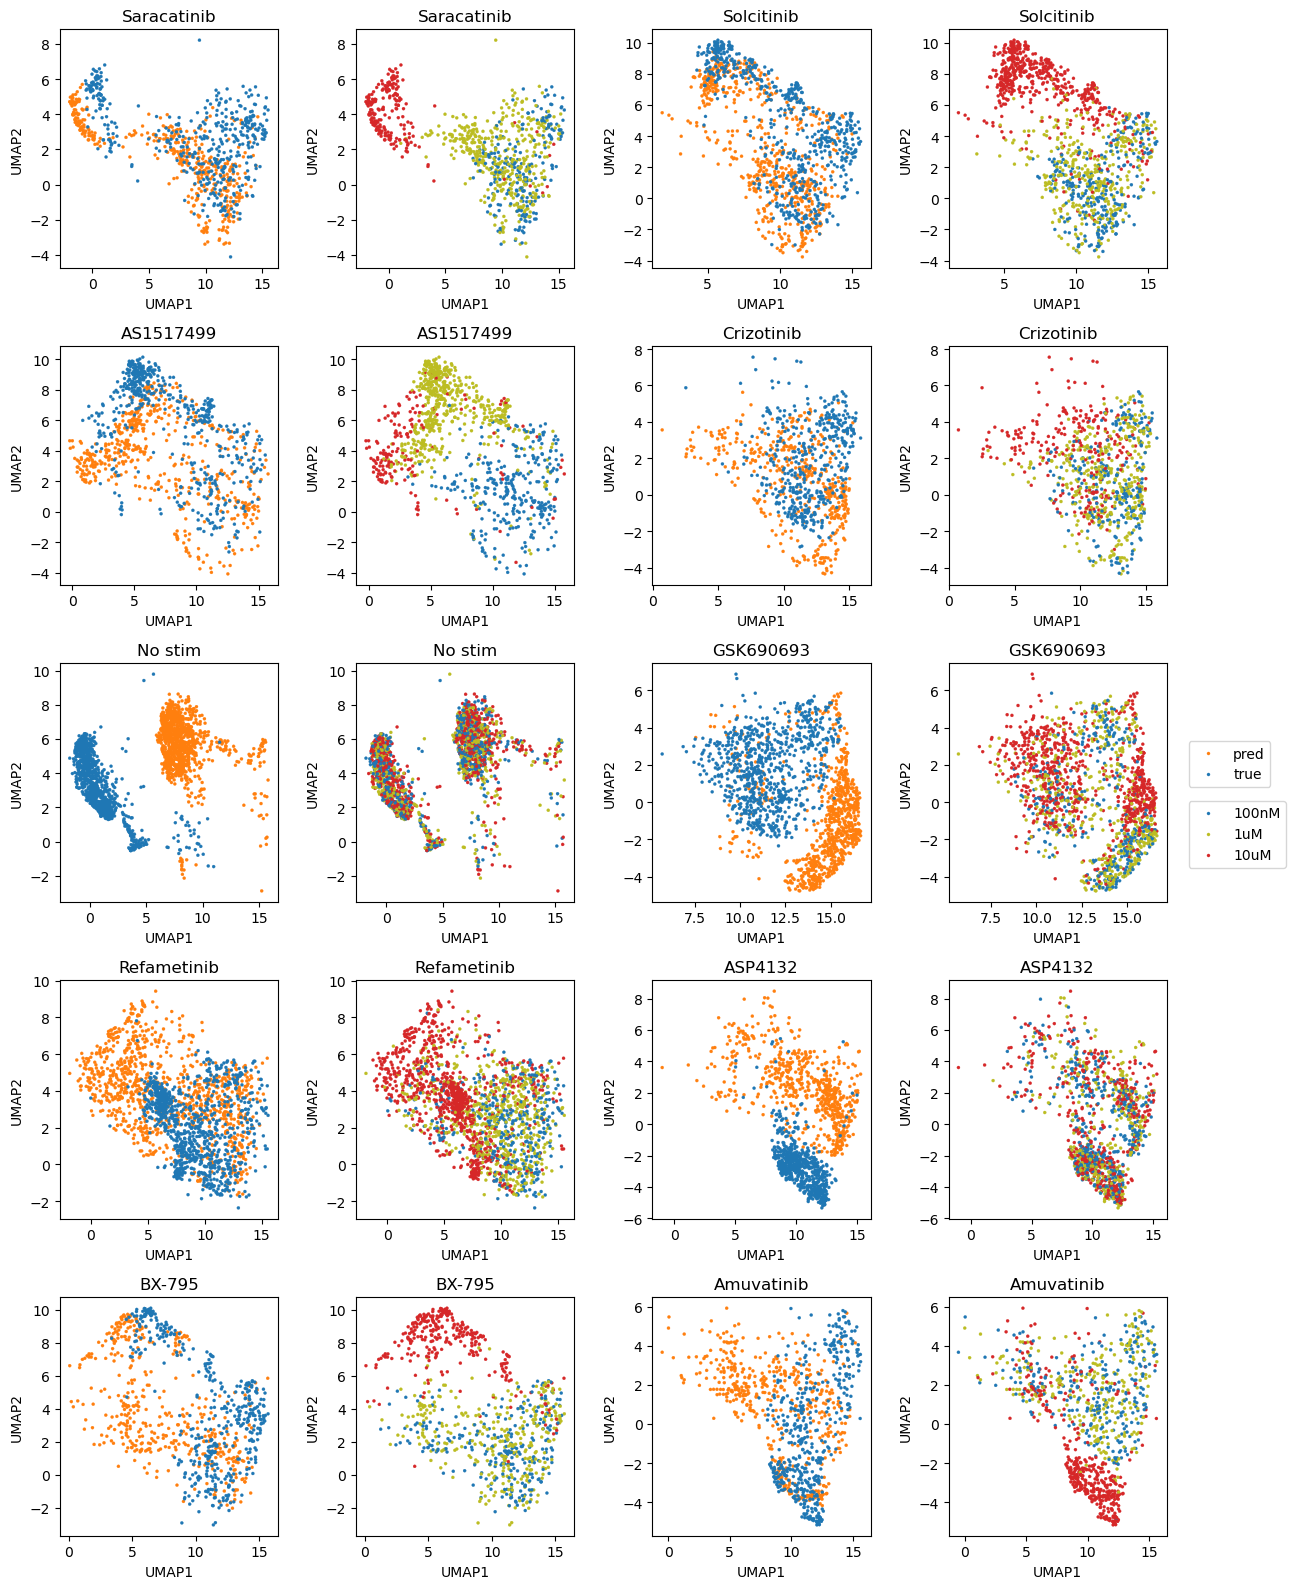

In [158]:
ncols=4
fig, ax = plt.subplots(len(adata.obs.labs.unique())//(ncols//2), ncols, figsize=(3*ncols, 3*len(adata.obs.labs.unique())//2+1
                                                                    ))
adata.obs["treatment"] = adata.obs.labs.map(treatment_idx)
adata.obs["dosage_"] = adata.obs.dosage.map(conc_idx)
class_pal = {"pred":pal[1], "true":pal[0]}
dosage_pal = {"100nM":pal[0], "1uM":pal[-2], "10uM":pal[3]}
i=0
for l in adata.obs.treatment.unique():
    pdf = pd.DataFrame({"UMAP1":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,0], "UMAP2":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,1], 
                        "class":adata[adata.obs.treatment == l,:].obs["class"], "dosage":adata[adata.obs.treatment == l,:].obs["dosage_"]})
    sns.scatterplot(pdf, x="UMAP1", y="UMAP2", hue='class', ax = ax[i//ncols,i%ncols], palette=class_pal, s=5, edgecolor=None)
    ax[i//ncols,i%ncols].get_legend().remove()
    ax[i//ncols,i%ncols].set_title(l)
    i+=1
    
    sns.scatterplot(pdf, x="UMAP1", y="UMAP2", hue='dosage', ax = ax[i//ncols,i%ncols], palette=dosage_pal, s = 5, edgecolor=None, hue_order=["100nM", "1uM", "10uM"])
    ax[i//ncols,i%ncols].get_legend().remove()
    ax[i//ncols,i%ncols].set_title(l)
    i+=1
    
    
    
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1,0.5), loc="lower left")
handles2, labels2 = ax[0,1].get_legend_handles_labels()
fig.legend(handles2, labels2, bbox_to_anchor=(1,0.5), loc="upper left")
plt.tight_layout()

/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/seaborn/relational.py:433: U

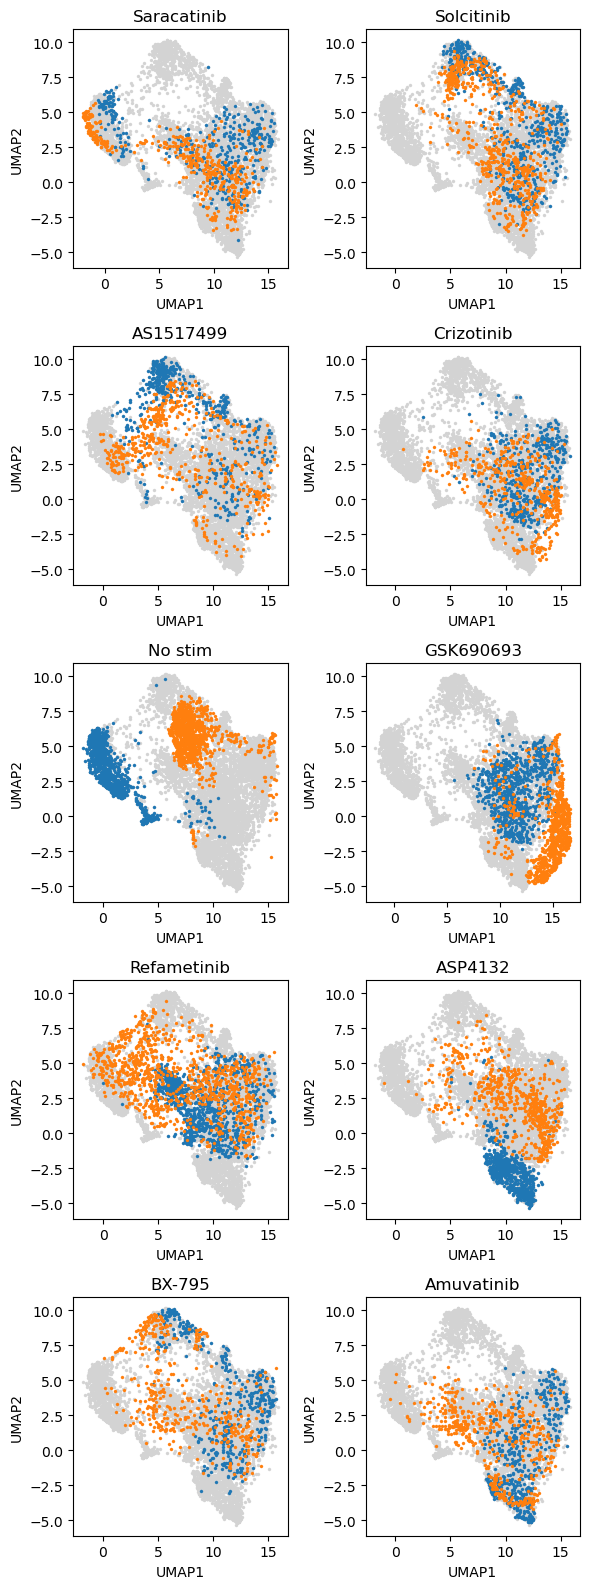

In [166]:
ncols=2
fig, ax = plt.subplots(len(adata.obs.labs.unique())//(ncols), ncols, figsize=(3*ncols, 3*len(adata.obs.labs.unique())//2+1
                                                                    ))
adata.obs["treatment"] = adata.obs.labs.map(treatment_idx)
adata.obs["dosage_"] = adata.obs.dosage.map(conc_idx)
class_pal = {"pred":pal[0], "true":pal[-3]}
dosage_pal = {"100nM":pal[0], "1uM":pal[-2], "10uM":pal[3]}
i=0
tdata = adata[adata.obs["class"] == "true",:]
adf = pd.DataFrame({"UMAP1":tdata.obsm["X_umap"][:,0], "UMAP2":tdata.obsm["X_umap"][:,1], 
                        "class":tdata.obs["class"], "dosage":tdata.obs["dosage_"]})
    
for l in adata.obs.treatment.unique():
    pdf = pd.DataFrame({"UMAP1":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,0], "UMAP2":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,1], 
                        "class":adata[adata.obs.treatment == l,:].obs["class"], "dosage":adata[adata.obs.treatment == l,:].obs["dosage_"]})
    sns.scatterplot(adf, x="UMAP1", y="UMAP2", c="lightgrey", ax = ax[i//ncols, i%ncols], s=5, edgecolor=None)
    sns.scatterplot(pdf.loc[pdf["class"] == "true"], x="UMAP1", y="UMAP2", c=pal[0], ax = ax[i//ncols, i%ncols], s=5, edgecolor=None)
    sns.scatterplot(pdf.loc[pdf["class"] == "pred"], x="UMAP1", y="UMAP2", c=pal[1], ax = ax[i//ncols, i%ncols], s=5, edgecolor=None)
    ax[i//ncols, i%ncols].set_title(l)
    #ax[i//ncols, i%ncols].get_legend().remove()
    i+=1
plt.tight_layout()

In [167]:
adata = pred_datas['EGWL_ott'][1]
adata.obs.labs = adata.obs.labs.astype("category")

/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ryuj6/miniforge3/envs/ot/lib/python3.11/site-packages/seaborn/relational.py:433: U

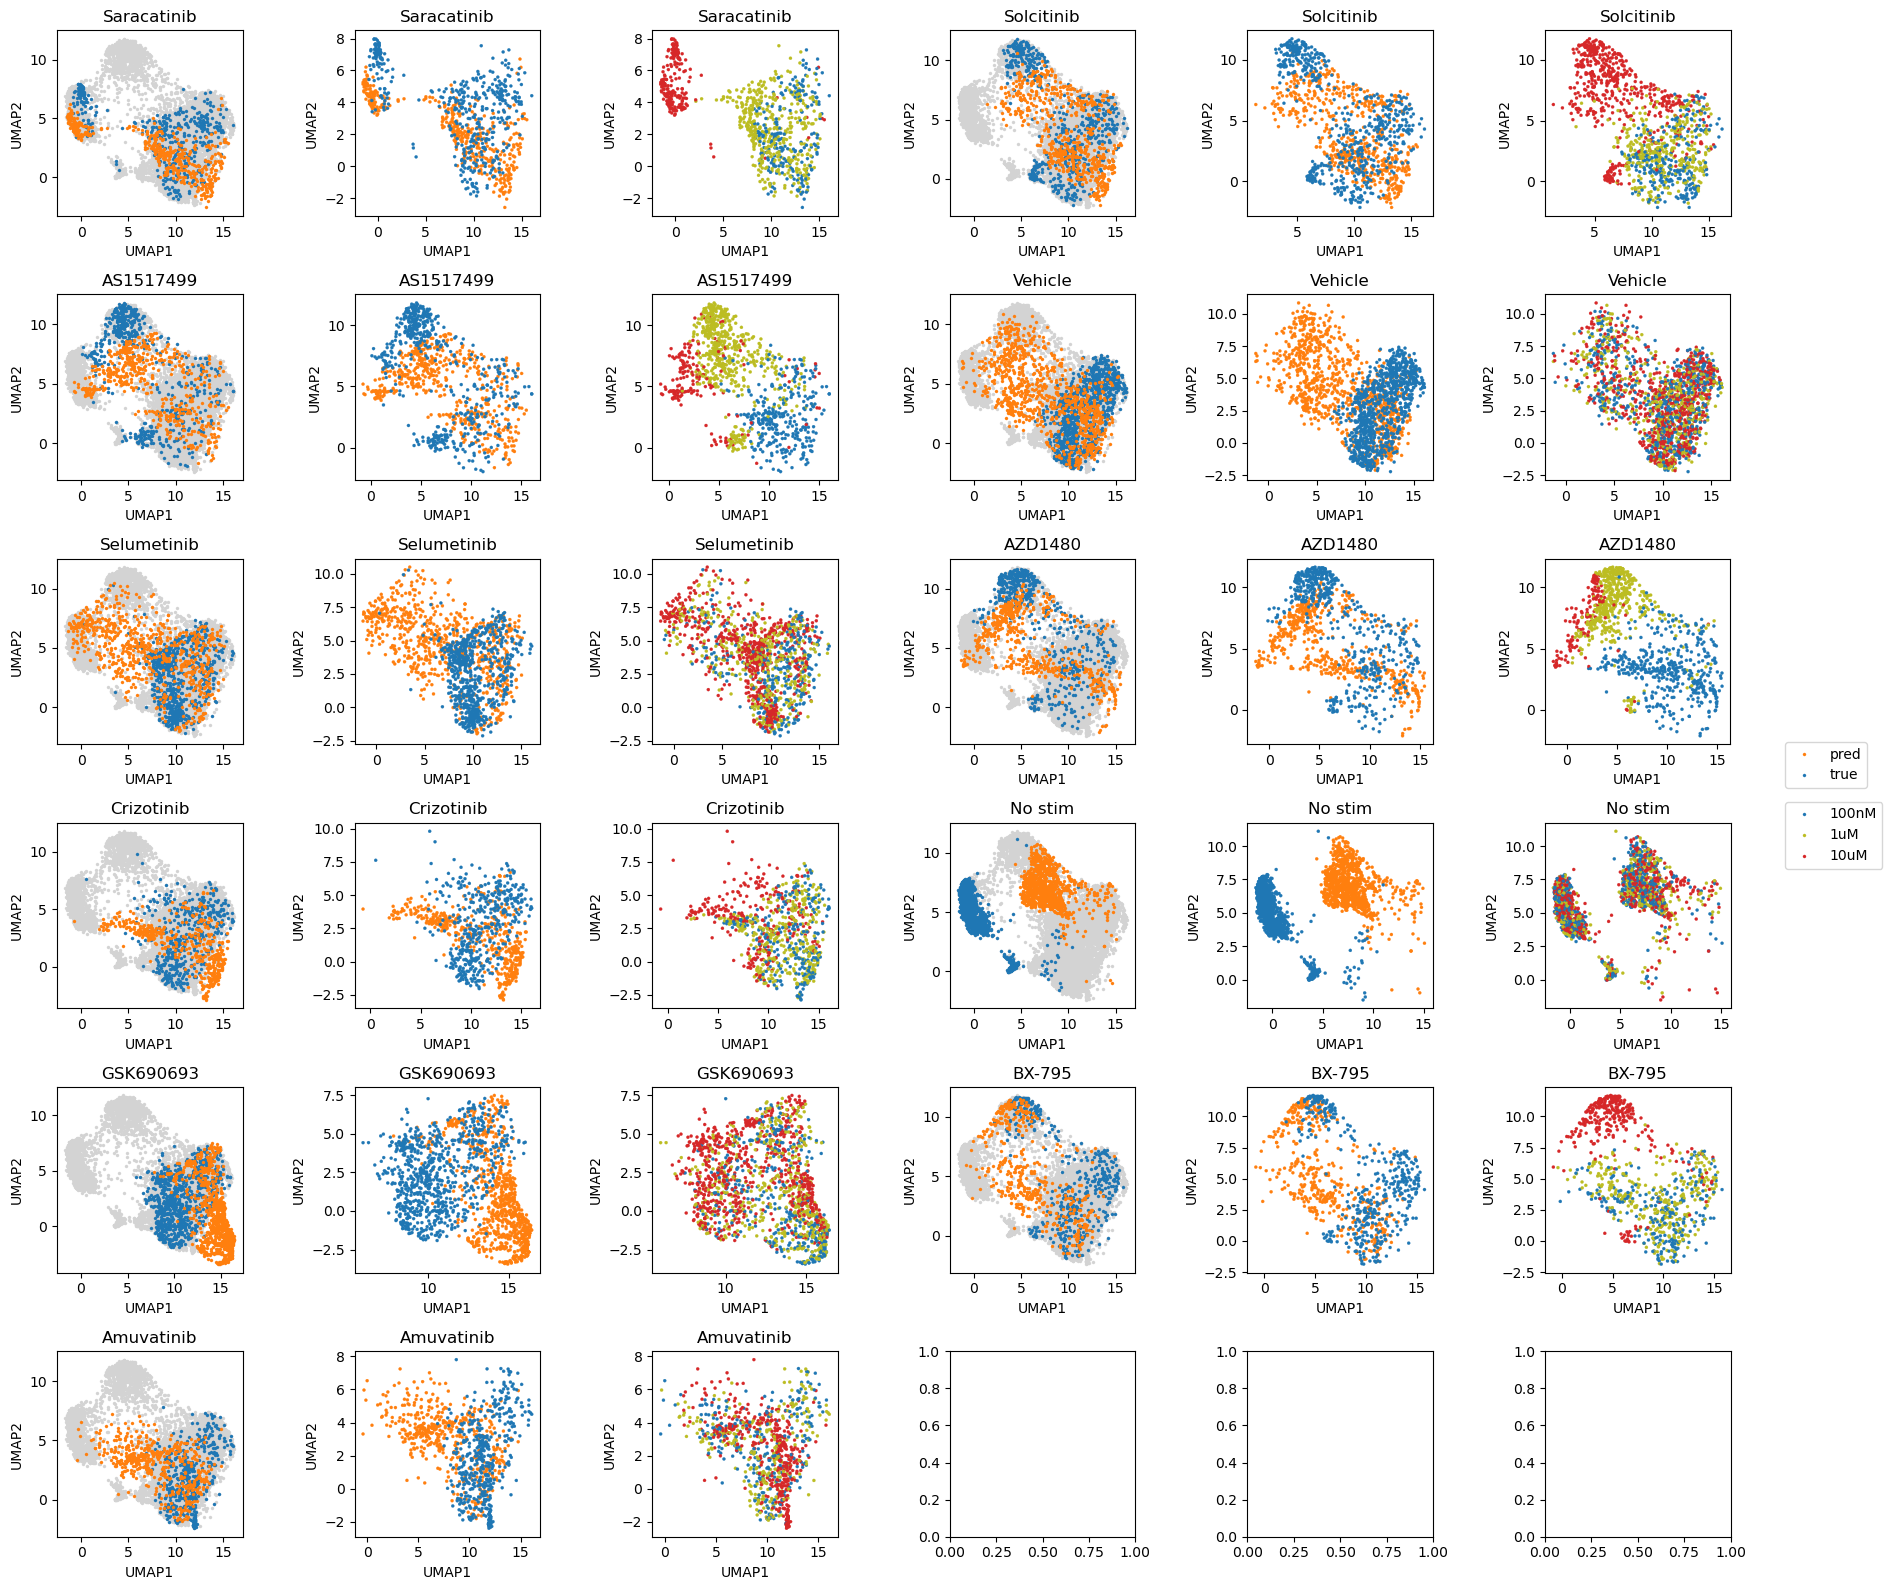

In [173]:
ncols=6
fig, ax = plt.subplots(len(adata.obs.labs.unique())//(ncols//3)+1, ncols, figsize=(3*ncols, 3*len(adata.obs.labs.unique())//2
                                                                    ))
adata.obs["treatment"] = adata.obs.labs.map(treatment_idx)
adata.obs["dosage_"] = adata.obs.dosage.map(conc_idx)
class_pal = {"pred":pal[1], "true":pal[0]}
dosage_pal = {"100nM":pal[0], "1uM":pal[-2], "10uM":pal[3]}
i=0
tdata = adata[adata.obs["class"] == "true",:]
adf = pd.DataFrame({"UMAP1":tdata.obsm["X_umap"][:,0], "UMAP2":tdata.obsm["X_umap"][:,1], 
                        "class":tdata.obs["class"], "dosage":tdata.obs["dosage_"]})
for l in adata.obs.treatment.unique():
    pdf = pd.DataFrame({"UMAP1":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,0], "UMAP2":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,1], 
                        "class":adata[adata.obs.treatment == l,:].obs["class"], "dosage":adata[adata.obs.treatment == l,:].obs["dosage_"]})
    sns.scatterplot(adf, x="UMAP1", y="UMAP2", c="lightgrey", ax = ax[i//ncols, i%ncols], s=5, edgecolor=None)
    sns.scatterplot(pdf.loc[pdf["class"] == "true"], x="UMAP1", y="UMAP2", c=pal[0], ax = ax[i//ncols, i%ncols], s=5, edgecolor=None)
    sns.scatterplot(pdf.loc[pdf["class"] == "pred"], x="UMAP1", y="UMAP2", c=pal[1], ax = ax[i//ncols, i%ncols], s=5, edgecolor=None)
    ax[i//ncols, i%ncols].set_title(l)
    #ax[i//ncols, i%ncols].get_legend().remove()
    i+=1
    pdf = pd.DataFrame({"UMAP1":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,0], "UMAP2":adata[adata.obs.treatment == l,:].obsm["X_umap"][:,1], 
                        "class":adata[adata.obs.treatment == l,:].obs["class"], "dosage":adata[adata.obs.treatment == l,:].obs["dosage_"]})
    sns.scatterplot(pdf, x="UMAP1", y="UMAP2", hue='class', ax = ax[i//ncols,i%ncols], palette=class_pal, s=5, edgecolor=None)
    ax[i//ncols,i%ncols].get_legend().remove()
    ax[i//ncols,i%ncols].set_title(l)
    i+=1
    
    sns.scatterplot(pdf, x="UMAP1", y="UMAP2", hue='dosage', ax = ax[i//ncols,i%ncols], palette=dosage_pal, s = 5, edgecolor=None, hue_order=["100nM", "1uM", "10uM"])
    ax[i//ncols,i%ncols].get_legend().remove()
    ax[i//ncols,i%ncols].set_title(l)
    i+=1

handles, labels = ax[0,1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1,0.5), loc="lower left")
handles2, labels2 = ax[0,2].get_legend_handles_labels()
fig.legend(handles2, labels2, bbox_to_anchor=(1,0.5), loc="upper left")
plt.setp(ax, box_aspect=1)
plt.tight_layout()

In [13]:
eps_to_val_to_pea = {eps:{} for eps in epsilons}
for eps in epsilons:
    for k, val_datas in d['pred'][eps].items():
        Y_pred, Y_true, Z = val_datas
        break

In [16]:
Y_pred

array([[ 0.0250858 ,  0.50265974,  0.59506359, ...,  0.01153718,
         0.2427542 ,  0.08149806],
       [ 0.1020986 ,  0.37876827,  1.42899389, ...,  0.02882756,
         0.27913478,  0.04282112],
       [ 0.11934561,  0.44449691,  1.87581675, ..., -0.00776927,
         0.31965856,  0.12636404],
       ...,
       [ 0.06442158,  0.39953268,  1.69231394, ...,  0.03648465,
         0.30838424,  0.13250347],
       [ 0.07161393,  0.42403691,  1.85030206, ..., -0.00219287,
         0.29376333,  0.12296023],
       [ 0.07969333,  0.3983978 ,  1.69489844, ...,  0.00236885,
         0.23895975,  0.12281313]])

In [22]:
np.corrcoef((Y_true / Y_v[None,:])[0, :], (Y_pred / Y_v[None,:])[0,:])

array([[1.        , 0.30431581],
       [0.30431581, 1.        ]])

In [23]:
np.corrcoef((Y_true)[0, :], (Y_pred)[0,:])

array([[1.        , 0.59459618],
       [0.59459618, 1.        ]])

In [15]:
Y_pred / Y_v[None,:]

array([[ 0.22804511,  1.30842988,  0.27546097, ...,  0.66484318,
         0.65762077,  0.90279364],
       [ 0.92813823,  0.98593876,  0.66149575, ...,  1.66122101,
         0.75617572,  0.47435036],
       [ 1.08492394,  1.15703127,  0.86833458, ..., -0.44771327,
         0.86595459,  1.39979599],
       ...,
       [ 0.58563127,  1.03998878,  0.78338927, ...,  2.10246988,
         0.83541245,  1.46780545],
       [ 0.65101405,  1.10377361,  0.85652358, ..., -0.1263667 ,
         0.79580445,  1.36209036],
       [ 0.72446071,  1.03703468,  0.78458566, ...,  0.13650768,
         0.64734161,  1.36046079]])

In [11]:
evals

{0.01: {(0.0,
   1.0):                       eval
  Pearson_corr      0.571861
  Spearman_corr     0.432571
  Pearson_samples   0.063807
  Spearman_samples  0.051786
  MSE               0.284675,
  (2.0,
   6.0):                       eval
  Pearson_corr      0.564338
  Spearman_corr     0.425791
  Pearson_samples   0.044577
  Spearman_samples  0.043031
  MSE               0.288896,
  (7.0,
   8.0):                       eval
  Pearson_corr      0.536159
  Spearman_corr     0.401101
  Pearson_samples   0.032395
  Spearman_samples  0.039395
  MSE               0.311632,
  (9.0,
   10.0):                       eval
  Pearson_corr      0.563759
  Spearman_corr     0.427674
  Pearson_samples   0.018571
  Spearman_samples  0.016025
  MSE               0.276488,
  (11.0,
   12.0):                       eval
  Pearson_corr      0.559859
  Spearman_corr     0.430239
  Pearson_samples   0.018768
  Spearman_samples  0.014877
  MSE               0.281086},
 0.001: {(0.0,
   1.0):                 

In [239]:
best_match_eps = {k:[] for k in methods}
for method in methods:
    for test_idx in range(5):
        try:
            with open(f"val_mlp.{method}.{test_idx}.pkl", "rb") as f:
                d = pkl.load(f)
        except:
            continue
        best_match_eps[method].append(d['best_eps']['pred'])

In [238]:
d['best_eps']

{'matching': 0.001, 'pred': 0.1, 'pred_full': 0.1}

In [240]:
best_match_eps

{'EOT_ott': [],
 'LEOT_ott': [],
 'EGW_ott': [],
 'EGW_all_ott': [],
 'EGWL_ott': [],
 'ECOOT': [],
 'ECOOTL': []}

In [ ]:
[]

In [230]:
d['best_eps']

{'matching': 1e-05, 'pred': 0.01, 'pred_full': 0.1}

In [201]:
d

{'eval_df':          Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples  \
 0.01000      0.594742       0.457621         0.064788          0.068167   
 0.00100      0.589177       0.453303         0.064776          0.065022   
 0.00010      0.562991       0.429819         0.052003          0.052581   
 0.00001      0.554509       0.417068         0.053378          0.052967   
 
               MSE  
 0.01000  0.269155  
 0.00100  0.272684  
 0.00010  0.288572  
 0.00001  0.295159  ,
 'eps': 0.01}

In [202]:
d.keys()

dict_keys(['eval_df', 'eps'])

In [43]:
vae_methods = ["VAE", "VAE_label"]

In [106]:
import torch

In [108]:
x = torch.tensor(0.)

In [112]:
x.unsqueeze(-1)

tensor([0.])

In [114]:
torch.multinomial(torch.tensor([0.0,1.0,2.9]), 1)

tensor([2])

In [104]:
res_dfs= []
for test_idx in [1,3]:
    ps = []
    pv = []
    ss = []
    sv = []
    mses = []
    for method in methods:
        with open(f"val_mlp.{method}.{test_idx}.best_eps.e.pkl", "rb") as f:
            d = pkl.load(f)
        ss.append(d['eval_df'].loc[d['eps'], "Spearman_samples"])
        sv.append(d['eval_df'].loc[d['eps'], "Spearman_corr"])
        ps.append(d['eval_df'].loc[d['eps'], "Pearson_samples"])
        pv.append(d['eval_df'].loc[d['eps'], "Pearson_corr"])
        mses.append(d['eval_df'].loc[d['eps'], "MSE"])
    for method in ["VAE", "VAE_label"]:
        with open(f"val_CV_{method}.{test_idx}.pkl", "rb") as f:
            d = pkl.load(f)
        ss.append(d['pred_evals'].loc["Spearman_samples", d['best_eps']["pred"]])
        sv.append(d['pred_evals'].loc["Spearman_corr", d['best_eps']["pred"]])
        ps.append(d['pred_evals'].loc["Pearson_samples", d['best_eps']["pred"]])
        pv.append(d['pred_evals'].loc["Pearson_corr", d['best_eps']["pred"]])
        mses.append(d['pred_evals'].loc["MSE", d['best_eps']["pred"]])
    res_dfs.append(pd.DataFrame({"method":methods + vae_methods, "Rv":pv, "rho_v":sv, "Rs":ps, "rho_s":ss, "MSE":mses,"test_idx":test_idx}, index=methods + vae_methods))
res_df = pd.concat(res_dfs)

In [216]:
d["log"][0]

{'match': {'n_iters_outer': Array(5, dtype=int32),
  'converged_inner': False,
  'converged_outer': Array(False, dtype=bool),
  'GW cost': Array(-inf, dtype=float32),
  'time': 1454.5452189445496,
  'cost_time': 0.26653552055358887},
 'match_pred': {'n_iters_outer': Array(5, dtype=int32),
  'converged_inner': True,
  'converged_outer': Array(True, dtype=bool),
  'GW cost': Array(0.8493354, dtype=float32),
  'time': 18.910339832305908,
  'cost_time': 0.1738905906677246},
 'match_lin': None,
 'mlp': {'time': -277.4779088497162}}

In [221]:
m = np.ones((3, 5)).mean(axis=0)

In [223]:
np.ones((3, 5)) / m[None,:]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [212]:
d["T"]['pred'][3.0].shape

(919, 919)

In [104]:
res_dfs= []
for test_idx in [1,3]:
    ps = []
    pv = []
    ss = []
    sv = []
    mses = []
    for method in methods:
        with open(f"val_mlp.{method}.{test_idx}.best_eps.e.pkl", "rb") as f:
            d = pkl.load(f)
        ss.append(d['eval_df'].loc[d['eps'], "Spearman_samples"])
        sv.append(d['eval_df'].loc[d['eps'], "Spearman_corr"])
        ps.append(d['eval_df'].loc[d['eps'], "Pearson_samples"])
        pv.append(d['eval_df'].loc[d['eps'], "Pearson_corr"])
        mses.append(d['eval_df'].loc[d['eps'], "MSE"])
    for method in ["VAE", "VAE_label"]:
        with open(f"val_CV_{method}.{test_idx}.pkl", "rb") as f:
            d = pkl.load(f)
        ss.append(d['pred_evals'].loc["Spearman_samples", d['best_eps']["pred"]])
        sv.append(d['pred_evals'].loc["Spearman_corr", d['best_eps']["pred"]])
        ps.append(d['pred_evals'].loc["Pearson_samples", d['best_eps']["pred"]])
        pv.append(d['pred_evals'].loc["Pearson_corr", d['best_eps']["pred"]])
        mses.append(d['pred_evals'].loc["MSE", d['best_eps']["pred"]])
    res_dfs.append(pd.DataFrame({"method":methods + vae_methods, "Rv":pv, "rho_v":sv, "Rs":ps, "rho_s":ss, "MSE":mses,"test_idx":test_idx}, index=methods + vae_methods))
res_df_test = pd.concat(res_dfs)

In [105]:
res_df.groupby("method").mean()

,Rv,rho_v,Rs,rho_s,MSE,test_idx
method,,,,,,
ECOOT,0.570473,0.441514,0.030747,0.033178,0.283657,2.0
ECOOTL,0.588969,0.450704,0.079800,0.074641,0.274635,2.0
EGWL_ott,0.590044,0.451245,0.077476,0.075021,0.273472,2.0
EGW_all_ott,0.574983,0.444205,0.037675,0.037803,0.280066,2.0
EGW_ott,0.591651,0.453769,0.066756,0.067952,0.272275,2.0
EOT_ott,0.546558,0.419937,0.009952,0.009705,0.294610,2.0
LEOT_ott,0.555710,0.421503,0.032937,0.030929,0.290874,2.0
VAE,0.548879,0.405345,0.045376,0.022930,0.298674,2.0
VAE_label,0.546667,0.404142,0.042604,0.029668,0.299346,2.0


In [87]:
with open(f"val_CV_EGWL_ott.{test_idx}.pkl", "rb") as f:
    d = pkl.load(f)

In [80]:
mod = d['T'][(1,
  128,
  0.0001)][(0.0, 1.0, 2.0)]

In [81]:
param_size = 0
for param in mod.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in mod.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

In [82]:
param_size

5531704

In [180]:
with open(f"val_CV_VAE.1.pkl", "rb") as f:
    d1 = pkl.load(f)
with open(f"val_CV_VAE.3.pkl", "rb") as f:
    d3 = pkl.load(f)

In [182]:
for k, v in d1["T"].items():
    for val_ids, model in 

{(1,
  128,
  0.0001): {(0.0, 1.0): MULTIVAE(
    (z_encoder_expression): Encoder(
      (encoder): FCLayers(
        (fc_layers): Sequential(
          (Layer 0): Sequential(
            (0): Linear(in_features=123, out_features=123, bias=True)
            (1): None
            (2): LayerNorm((123,), eps=1e-05, elementwise_affine=False)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Dropout(p=0.1, inplace=False)
          )
          (Layer 1): Sequential(
            (0): Linear(in_features=123, out_features=123, bias=True)
            (1): None
            (2): LayerNorm((123,), eps=1e-05, elementwise_affine=False)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (mean_encoder): Linear(in_features=123, out_features=128, bias=True)
      (var_encoder): Linear(in_features=123, out_features=128, bias=True)
    )
    (l_encoder_expression): LibrarySizeEncoder(
      (px_decoder): FCLayers

### Baseline

In [174]:
with open(f"val_CV_MLP_baseline.1.pkl", "rb") as f:
    d1 = pkl.load(f)
with open(f"val_CV_MLP_baseline.3.pkl", "rb") as f:
    d3 = pkl.load(f)

In [175]:
d1

{'pred_evals':                    perfect    dosage    random
 Pearson_corr      0.109068  0.088433  0.089178
 Spearman_corr     0.110667  0.048953  0.040158
 Pearson_samples   0.148763  0.087891  0.065520
 Spearman_samples  0.137107  0.085386  0.068506
 MSE               0.267141  0.268390  0.270671,
 'match_evals': {'perfect': {'foscttm': 0.0     0.0
   1.0     0.0
   2.0     0.0
   6.0     0.0
   7.0     0.0
   8.0     0.0
   9.0     0.0
   10.0    0.0
   dtype: float64,
   'dfracs': 0.0     1.0
   1.0     1.0
   2.0     1.0
   6.0     1.0
   7.0     1.0
   8.0     1.0
   9.0     1.0
   10.0    1.0
   dtype: float64,
   'rel_dfracs': 0.0     1.0
   1.0     1.0
   2.0     1.0
   6.0     1.0
   7.0     1.0
   8.0     1.0
   9.0     1.0
   10.0    1.0
   dtype: float64},
  'dosage': {'foscttm': 0.0     0.346490
   1.0     0.404672
   2.0     0.381863
   6.0     0.443420
   7.0     0.491456
   8.0     0.463009
   9.0     0.440406
   10.0    0.490088
   dtype: float64,
   'dfracs': 0.0  

In [176]:
mean_metrics1 = {}
for tlab, metric in d1['match_evals'].items():
    mean_metrics1[tlab] = {k:v.mean() for k, v in metric.items()}
mean_metrics3 = {}
for tlab, metric in d3['match_evals'].items():
    mean_metrics3[tlab] = {k:v.mean() for k, v in metric.items()}
match_mat1 = pd.DataFrame(mean_metrics1).T[['foscttm', 'rel_dfracs']]
match_mat3 = pd.DataFrame(mean_metrics3).T[['foscttm', 'rel_dfracs']]

In [177]:
(match_mat1 + match_mat3)/2

,foscttm,rel_dfracs
perfect,0.000000,1.0
dosage,0.430232,1.0
random,0.500000,0.0


In [178]:
pred_mat1 = d1['pred_evals'].T
pred_mat3 = d3['pred_evals'].T

In [179]:
(pred_mat1 + pred_mat3)/2

,Pearson_corr,Spearman_corr,Pearson_samples,Spearman_samples,MSE
perfect,0.106004,0.107768,0.150018,0.137978,0.269031
dosage,0.079407,0.043434,0.084321,0.082763,0.271609
random,0.082397,0.032998,0.064776,0.068050,0.272175


In [182]:
match_mat = pd.DataFrame(mean_metrics).T[['foscttm', 'rel_dfracs']]

,foscttm,rel_dfracs
perfect,0.000000,1.0
dosage,0.432676,1.0
random,0.500000,0.0


In [195]:
d3['match_evals']['random']

{'foscttm': 0.0    0.5
 1.0    0.5
 2.0    0.5
 3.0    0.5
 4.0    0.5
 5.0    0.5
 6.0    0.5
 7.0    0.5
 8.0    0.5
 dtype: float64,
 'dfracs': 0.0    0.377426
 1.0    0.360429
 2.0    0.407982
 3.0    0.340393
 4.0    0.363766
 5.0    0.395582
 6.0    0.349813
 7.0    0.335494
 8.0    0.366878
 dtype: float64,
 'rel_dfracs': 0.0    0.0
 1.0    0.0
 2.0    0.0
 3.0    0.0
 4.0    0.0
 5.0    0.0
 6.0    0.0
 7.0    0.0
 8.0    0.0
 dtype: float64}

In [184]:
pred_mat = d1['pred_evals'].T

In [185]:
pred_mat

,Pearson_corr,Spearman_corr,Pearson_samples,Spearman_samples,MSE
perfect,0.605870,0.445490,0.149874,0.136561,0.266382
dosage,0.597546,0.455491,0.087714,0.084977,0.268230
random,0.592257,0.454180,0.068131,0.069322,0.269885


In [135]:
pd.concat(d['dfracs'][0.01], axis=1)

,0,1,2,3,4
3.0,0.007680,NaN,0.007912,0.005159,0.008041
4.0,-0.109725,NaN,-0.109638,-0.109246,-0.105701
5.0,-0.009829,0.028763,NaN,-0.013635,0.015918
6.0,-0.017414,0.002783,NaN,-0.024206,-0.011081
7.0,-0.003252,-0.001943,-0.002920,NaN,-0.002542
8.0,-0.011491,-0.022474,-0.015247,NaN,-0.015082
11.0,-0.002883,0.015859,0.006562,-0.000144,NaN
12.0,-0.049611,-0.057544,-0.048094,-0.046606,NaN
0.0,NaN,0.091874,0.099302,0.001948,0.100519
1.0,NaN,-0.012860,-0.016071,-0.023803,-0.004515


In [132]:
pd.DataFrame(d['dfracs'])

,0.01000,0.00100,0.00010,0.00001
0,3.0 0.007680 4.0 -0.109725 5.0 -0.00...,3.0 0.014111 4.0 -0.199545 5.0 -0.08...,3.0 0.006517 4.0 -0.228524 5.0 -0.08...,3.0 -0.020797 4.0 -0.179269 5.0 -0.09...
1,0.0 0.091874 1.0 -0.012860 2.0 0.14...,0.0 0.128442 1.0 -0.088033 2.0 0.18...,0.0 0.220378 1.0 -0.144126 2.0 0.18...,0.0 0.109644 1.0 -0.186324 2.0 0.13...
2,0.0 0.099302 1.0 -0.016071 2.0 0.12...,0.0 0.050268 1.0 -0.108010 2.0 0.09...,0.0 0.014198 1.0 -0.144159 2.0 0.11...,0.0 -0.076441 1.0 -0.105604 2.0 0.05...
3,0.0 0.001948 1.0 -0.023803 2.0 0.11...,0.0 -0.157004 1.0 -0.069870 2.0 0.22...,0.0 -0.193048 1.0 -0.045698 2.0 0.28...,0.0 -0.196417 1.0 -0.061155 2.0 0.23...
4,0.0 0.100519 1.0 -0.004515 2.0 0.12607...,0.0 0.114774 1.0 -0.058958 2.0 0.16292...,0.0 0.116274 1.0 -0.038098 2.0 0.14725...,0.0 0.170552 1.0 -0.051216 2.0 0.12368...


In [125]:
pd.DataFrame(d['dfracs']).mean(axis=0)

0.01000   -0.048603
0.00100   -0.054265
0.00010   -0.053256
0.00001   -0.043733
dtype: float64

In [138]:
pd.Series({k:pd.concat(d['dfracs'][k], axis=1).mean().mean() for k in d['dfracs'].keys()}).idxmax()

0.01000    0.000628
0.00100   -0.017589
0.00010   -0.013292
0.00001   -0.002830
dtype: float64

In [167]:
res_dfs= []
for test_idx in [1,3]:
    fs = []
    ds = []
    for method in methods:
        with open(f"val_CV_{method}.{test_idx}.e.pkl", "rb") as f:
            d = pkl.load(f)
        fs.append(d['matching_evals'][d['best_eps']['matching']])
        try:
            ds.append(pd.DataFrame(d['dfracs']).mean(axis=0)[d['best_eps']['matching']])
        except TypeError:
            ds.append(pd.Series({k:pd.concat(d['dfracs'][k], axis=1).mean().mean() for k in d['dfracs'].keys()})[d['best_eps']['matching']])
    for method in ["VAE", "VAE_label"]:
        with open(f"val_CV_{method}.{test_idx}.e.pkl", "rb") as f:
            d = pkl.load(f)
        fs.append(d['matching_evals'][d['best_eps']['matching']])
        # matching
        dfs = []
        for lam, val_data_evals in d['dfracs'].items():
            for ks_evals in val_data_evals:
                dfs.append(pd.DataFrame(ks_evals).mean(axis=0))
        ds.append(pd.concat(dfs, axis=1).mean(axis=1).max())
    res_dfs.append(pd.DataFrame({"method":methods + vae_methods, "foscttm":fs, "dfracs":ds, "test_idx":test_idx}, index=methods + vae_methods))
res_df_matching = pd.concat(res_dfs)

In [170]:
res_df.groupby("method").mean()

,Rv,rho_v,Rs,rho_s,MSE,test_idx
method,,,,,,
ECOOT,0.570473,0.441514,0.030747,0.033178,0.283657,2.0
ECOOTL,0.588969,0.450704,0.079800,0.074641,0.274635,2.0
EGWL_ott,0.590044,0.451245,0.077476,0.075021,0.273472,2.0
EGW_all_ott,0.574983,0.444205,0.037675,0.037803,0.280066,2.0
EGW_ott,0.591651,0.453769,0.066756,0.067952,0.272275,2.0
EOT_ott,0.546558,0.419937,0.009952,0.009705,0.294610,2.0
LEOT_ott,0.555710,0.421503,0.032937,0.030929,0.290874,2.0
VAE,0.548879,0.405345,0.045376,0.022930,0.298674,2.0
VAE_label,0.546667,0.404142,0.042604,0.029668,0.299346,2.0


In [169]:
res_df_matching.groupby("method").mean()[['foscttm', 'dfracs']]

,foscttm,dfracs
method,,
ECOOT,0.462927,-0.019541
ECOOTL,0.391912,0.183682
EGWL_ott,0.395232,0.201896
EGW_all_ott,0.438205,-0.017724
EGW_ott,0.480542,0.015312
EOT_ott,0.469985,-0.048956
LEOT_ott,0.469985,0.003097
VAE,0.361067,0.134498
VAE_label,0.377365,0.133874


In [37]:
ps

[0.0126024,
 0.0347702,
 0.0689698,
 0.0343136,
 0.08011120000000001,
 0.029099399999999997,
 0.078459,
 0.03690669086547075,
 0.048616054683666615]

In [151]:
with open(f"val_CV_VAE.0.e.pkl", "rb") as f:
    d = pkl.load(f)

In [160]:
pd.DataFrame(ks_evals[0])

,5,10,25,50
5.0,0.073112,0.042404,0.012448,0.005680
6.0,0.004521,-0.001476,-0.006908,-0.006344
7.0,0.025742,0.023937,0.020566,0.013944
8.0,-0.147609,-0.115981,-0.076074,-0.057995
9.0,-0.136438,-0.107929,-0.090433,-0.071829
10.0,0.022701,0.016418,0.010136,0.006738
11.0,0.005227,0.014838,0.010719,0.015868
12.0,-0.058827,-0.059455,-0.029705,-0.008930


In [161]:
dfs = []
for lam, val_data_evals in d['dfracs'].items():
    for ks_evals in val_data_evals:
        dfs.append(pd.DataFrame(ks_evals).mean(axis=0))

In [165]:
pd.concat(dfs, axis=1).mean(axis=1).max()

5     0.113879
10    0.109253
25    0.100187
50    0.090807
dtype: float64

In [31]:
d.keys()

dict_keys(['matching_evals', 'pred_evals', 'T', 'log', 'best_eps'])

In [32]:
d['best_eps']

{'matching': (100, 128, 0.0001), 'pred': (100, 128, 0.0001)}

In [33]:
d['pred_evals'].loc["Pearson_samples", d['best_eps']["pred"]]

0.03690669086547075

In [21]:
ps

[0.0126024,
 0.0347702,
 0.0689698,
 0.0343136,
 0.08011120000000001,
 0.029099399999999997,
 0.078459]